In [18]:
import numpy as np
import torch
import torch.nn as nn
import torch.autograd as tgrad
import torch.optim as optim
import matplotlib.pyplot as plt
import scipy.stats as si

In [19]:
K = 40              # Strike Price
r = 0.05            # Interest Rate
sigma = 0.25        # Annual volatility of asset
T = 1               # Time to maturity
S_range = [0, 500]  # Input ranges for asset price
t_range = [0, T] 
V_range = [0.03, 0.06]# Input ranges for time
V = 0.03
Rho_range = [-1,1]
gs = lambda x: np.fmax(x - K, 0)  # Instrinsic value of call option

In [20]:
#considered the values from some examples.
k_v = 0.1
k_r = 0.1                 #rate at which v_t reverts to mu
mu_v = 0.2953             # long variance
mu_r = 0.2953              # long variance
Sigma_v = 0.001            # volatility of the volatility
Sigma_r = 0.001            # volatility of the volatility
Rho_2 = 0
Rho_3 = 0.3

In [21]:
def black_scholes_call_div(X, K, r, sigma):
    T = X[:, 0]
    S = X[:, 1]

    d1 = (np.log(S/K) + (r + 0.5*sigma**2)*T) / (sigma*np.sqrt(T))
    d2 = (np.log(S/K) + (r - 0.5*sigma**2)*T) / (sigma*np.sqrt(T))
    
    call = (S*si.norm.cdf(d1, 0.0, 1.0) - K*np.exp(-r*T)*si.norm.cdf(d2, 0.0, 1.0))
    return call

In [22]:
def get_diff_data(n):
    X = np.concatenate([np.random.uniform(*t_range, (n, 1)), 
                        np.random.uniform(*S_range, (n, 1)),
                        np.random.uniform(*V_range, (n, 1)),
                        np.random.uniform(*Rho_range, (n, 1))], axis=1)
    y = np.zeros((n, 1))
    return X, y

def get_evp_data(n):
    X = np.concatenate([np.ones((n, 1)),
                    np.random.uniform(*S_range, (n, 1)),
                    np.random.uniform(*V_range, (n, 1)),
                    np.random.uniform(*Rho_range, (n, 1))], axis=1)
    y = gs(X[:, 1]).reshape(-1, 1)
    
    return X, y

def get_bvp_data(n):
    X1 = np.concatenate([np.random.uniform(*t_range, (n, 1)),
                        S_range[0] * np.ones((n, 1)),
                        V_range[0] * np.ones((n, 1)),
                        Rho_range[0] * np.ones((n, 1))], axis=1)
    y1 = np.zeros((n, 1))
    
    X2 = np.concatenate([np.random.uniform(*t_range, (n, 1)), 
                        S_range[-1] * np.ones((n, 1)),
                        V_range[-1] * np.ones((n, 1)),
                        Rho_range[-1] * np.ones((n, 1))], axis=1)
    y2 = black_scholes_call_div(X2, K, r, sigma).reshape(-1, 1)
    # y2 = np.array([black_scholes_call_div(X, K, T, r, sigma) for (T, X) in X2]).reshape(-1, 1)
    # y2 = (S_range[-1] - K*np.exp(-r*(T-X2[:, 0].reshape(-1)))).reshape(-1, 1)
    
    return X1, y1, X2, y2

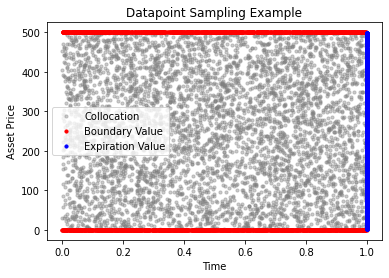

In [23]:
X1, _ = get_diff_data(5000)
X21, _, X22, _ = get_bvp_data(1000)
X3, _ = get_evp_data(1000)

plt.scatter(X1[:,0], X1[:,1], color='gray', s=10, alpha=0.4, label='Collocation')
plt.scatter(X21[:,0], X21[:,1], color='red', s=10, label='Boundary Value')
plt.scatter(X22[:,0], X22[:,1], color='red', s=10)
plt.scatter(X3[:,0], X3[:,1], color='blue', s=10, label='Expiration Value')

plt.xlabel('Time')
plt.ylabel('Asset Price')
plt.title('Datapoint Sampling Example')
plt.legend()

plt.show()

In [24]:
class PINN(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim=1):
        super(PINN, self).__init__()
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.output_dim = output_dim

        self.hidden_layer1 = nn.Linear(self.input_dim, self.hidden_dim)
        self.hidden_layer2 = nn.Linear(self.hidden_dim, self.hidden_dim)
        self.hidden_layer3 = nn.Linear(self.hidden_dim, self.hidden_dim)
        self.hidden_layer4 = nn.Linear(self.hidden_dim, self.hidden_dim)
        self.hidden_layer5 = nn.Linear(self.hidden_dim, self.hidden_dim)
        self.output_layer = nn.Linear(self.hidden_dim, self.output_dim)

        # self.activation = torch.sigmoid
        self.activation = torch.relu

        # torch.nn.init.zeros_(self.hidden_layer1.weight.data)
        # torch.nn.init.zeros_(self.hidden_layer2.weight.data)
        # torch.nn.init.zeros_(self.hidden_layer3.weight.data)
        # torch.nn.init.zeros_(self.hidden_layer4.weight.data)
        # torch.nn.init.zeros_(self.hidden_layer5.weight.data)
        # torch.nn.init.zeros_(self.output_layer.weight.data)
    
        # torch.nn.init.kaiming_normal_(self.hidden_layer1.weight.data)
        # torch.nn.init.kaiming_normal_(self.hidden_layer2.weight.data)
        # torch.nn.init.kaiming_normal_(self.hidden_layer3.weight.data)
        # torch.nn.init.kaiming_normal_(self.hidden_layer4.weight.data)
        # torch.nn.init.kaiming_normal_(self.hidden_layer5.weight.data)
        # torch.nn.init.kaiming_normal_(self.output_layer.weight.data)

        torch.nn.init.xavier_normal_(self.hidden_layer1.weight.data)
        torch.nn.init.xavier_normal_(self.hidden_layer2.weight.data)
        torch.nn.init.xavier_normal_(self.hidden_layer3.weight.data)
        torch.nn.init.xavier_normal_(self.hidden_layer4.weight.data)
        torch.nn.init.xavier_normal_(self.hidden_layer5.weight.data)
        torch.nn.init.xavier_normal_(self.output_layer.weight.data)

    def forward(self, x):
        inputs = x
        layer1_out = self.activation(self.hidden_layer1(inputs))
        layer2_out = self.activation(self.hidden_layer2(layer1_out))
        layer3_out = self.activation(self.hidden_layer3(layer2_out))
        layer4_out = self.activation(self.hidden_layer4(layer3_out))
        layer5_out = self.activation(self.hidden_layer5(layer4_out))
        out = self.output_layer(layer5_out)
        return out

In [25]:
model = PINN(4, 128, 1)


n_epochs = 10000
samples = {"pde": 5000, "bvp":5000, "evp":5000}
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=5e-5)

In [26]:
loss_hist = []

for epoch in range(n_epochs):
    # Loss based on PDE
    X1, y1 = get_diff_data(samples['pde'])
    X1 = torch.from_numpy(X1).float().requires_grad_()
    y1 = torch.from_numpy(y1).float()
    
    y1_hat = model(X1)
    
    grads_1 = tgrad.grad(y1_hat, X1, grad_outputs=torch.ones(y1_hat.shape), retain_graph=True, create_graph=True, only_inputs=True)[0]
    dC_dt, dC_dS, dC_dV, dC_dRho = grads_1[:, 0].view(-1, 1), grads_1[:, 1].view(-1, 1), grads_1[:, 2].view(-1, 1),grads_1[:, 3].view(-1, 1)
    
    grads_2 = tgrad.grad(dC_dS, X1, grad_outputs=torch.ones(dC_dS.shape), create_graph=True, only_inputs=True)[0]
    d2C_dS2 = grads_2[:, 1].view(-1, 1)
    
    grads_21 = tgrad.grad(dC_dV, X1, grad_outputs=torch.ones(dC_dV.shape), create_graph=True, only_inputs=True)[0]
    d2C_dV2 = grads_21[:, 2].view(-1, 1)
    
    grads_22 = tgrad.grad(dC_dRho, X1, grad_outputs=torch.ones(dC_dRho.shape), create_graph=True, only_inputs=True)[0]
    d2C_dRho2 = grads_22[:, 3].view(-1, 1)
    
    grads_31 = tgrad.grad(dC_dS, X1, grad_outputs=torch.ones(dC_dS.shape), create_graph=True, only_inputs=True)[0]
    d2C_dSdV = grads_2[:, 2].view(-1, 1)
    
    grads_32 = tgrad.grad(dC_dV, X1, grad_outputs=torch.ones(dC_dV.shape), create_graph=True, only_inputs=True)[0]
    d2C_dVdRho = grads_2[:, 3].view(-1, 1)
    
    grads_33 = tgrad.grad(dC_dRho, X1, grad_outputs=torch.ones(dC_dRho.shape), create_graph=True, only_inputs=True)[0]
    d2C_dRhodS = grads_2[:, 1].view(-1, 1)
    
    S1 = X1[:, 1].view(-1, 1)
    Rho1 = X1[:, 3].view(-1, 1)
    
    pde_loss = criterion(-dC_dt, (r*S1)*dC_dS + (k_v*(mu_v - V))*dC_dV + (k_r*(mu_r - Rho1))*dC_dRho + 
                     (0.5 * (V * (S1**2))) * d2C_dS2 + (0.5 * (Sigma_v ** 2) * V)* d2C_dV2 +
                     (0.5 * (Sigma_r **2))* d2C_dRho2 + (Sigma_v * S1 * V* Rho1) * d2C_dSdV + 
                     (Sigma_v * Sigma_r * Rho_3  * (V ** 0.5)) * d2C_dVdRho + (Sigma_r * Rho_2 * S1 * (V ** 0.5)) * d2C_dRhodS - r*y1_hat)
    
    # Loss based on boundary conditions
    X21, y21, X22, y22 = get_bvp_data(samples['bvp'])
    
    X21 = torch.from_numpy(X21).float()
    y21 = torch.from_numpy(y21).float()
    
    X22 = torch.from_numpy(X22).float()
    y22 = torch.from_numpy(y22).float()
    
    y21_hat = model(X21)
    bvp1_loss = criterion(y21, y21_hat)
    
    y22_hat = model(X22)
    bvp2_loss = criterion(y22, y22_hat)
    
    # Loss based on expirational conditions
    X3, y3 = get_evp_data(samples['evp'])
    
    X3 = torch.from_numpy(X3).float()
    y3 = torch.from_numpy(y3).float()
    
    y3_hat = model(X3)
    evp_loss = criterion(y3, y3_hat)
    
    # Combining the loss functions
    loss = pde_loss + bvp1_loss + bvp2_loss + evp_loss
    
    # Backpropagation and update
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    loss_hist.append(loss.item())
    if epoch % 500 == 0:
        print(f'{epoch}/{n_epochs} PDE Loss: {pde_loss.item():.5f}, BVP1 Loss: {bvp1_loss.item():.5f}, BVP2 Loss: {bvp2_loss.item():.5f}, EVP Loss: {evp_loss.item():.5f},')
    

0/10000 PDE Loss: 0.00219, BVP1 Loss: 0.00221, BVP2 Loss: 226978.37500, EVP Loss: 68784.37500,
500/10000 PDE Loss: 3.47352, BVP1 Loss: 0.00034, BVP2 Loss: 11.77435, EVP Loss: 160.30077,
1000/10000 PDE Loss: 6.36932, BVP1 Loss: 0.00003, BVP2 Loss: 0.73900, EVP Loss: 2.55294,
1500/10000 PDE Loss: 0.33167, BVP1 Loss: 0.00001, BVP2 Loss: 1.09696, EVP Loss: 0.43706,
2000/10000 PDE Loss: 0.11003, BVP1 Loss: 0.00000, BVP2 Loss: 0.33239, EVP Loss: 0.08588,
2500/10000 PDE Loss: 0.10440, BVP1 Loss: 0.00000, BVP2 Loss: 0.28373, EVP Loss: 0.17109,
3000/10000 PDE Loss: 0.09626, BVP1 Loss: 0.00001, BVP2 Loss: 0.32392, EVP Loss: 0.22357,
3500/10000 PDE Loss: 0.10239, BVP1 Loss: 0.00001, BVP2 Loss: 0.27154, EVP Loss: 0.14556,
4000/10000 PDE Loss: 0.08789, BVP1 Loss: 0.00000, BVP2 Loss: 0.39688, EVP Loss: 0.05397,
4500/10000 PDE Loss: 0.08139, BVP1 Loss: 0.00000, BVP2 Loss: 0.51526, EVP Loss: 0.09349,
5000/10000 PDE Loss: 0.09111, BVP1 Loss: 0.00000, BVP2 Loss: 0.25503, EVP Loss: 0.23568,
5500/10000 PD

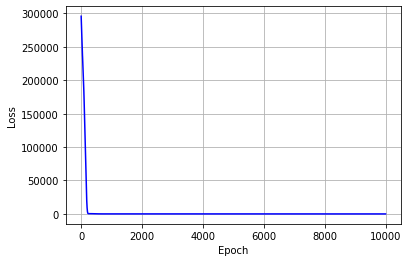

In [27]:
x_len = np.arange(len(loss_hist))
plt.plot(x_len, loss_hist, c='blue', label="Train-set Loss")
plt.grid()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()


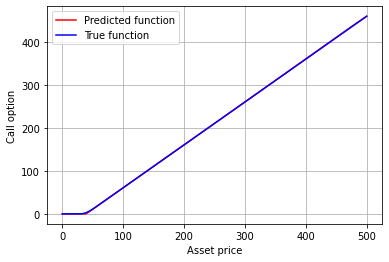

In [28]:
# This function resolves redundant legend issues when using matplotlib library.
# Retrieved from https://stackoverflow.com/a/56253636
def legend_without_duplicate_labels(ax):
    handles, labels = ax.get_legend_handles_labels()
    unique = [(h, l) for i, (h, l) in enumerate(zip(handles, labels)) if l not in labels[:i]]
    ax.legend(*zip(*unique))

np.seterr(divide = 'ignore')
fig, ax = plt.subplots()

X_cmp = np.concatenate([0.5*np.ones((1000, 1)),
                        np.linspace(0, 500, num=1000).reshape(-1, 1),
                       np.linspace(0.03, 0.06, num=1000).reshape(-1, 1),
                       np.linspace(-1, 1, num=1000).reshape(-1, 1)], axis=1)
Y_pred = model(torch.from_numpy(X_cmp).float().requires_grad_()).cpu().detach()
Y_true = black_scholes_call_div(X_cmp, K, r, sigma)

X_cmp = np.linspace(0, 500, num=1000)

ax.plot(X_cmp, Y_pred, c='red', label="Predicted function")
ax.plot(X_cmp, Y_true, c='blue', label="True function")

legend_without_duplicate_labels(ax)

plt.grid()
plt.xlabel('Asset price')
plt.ylabel('Call option')

plt.show()

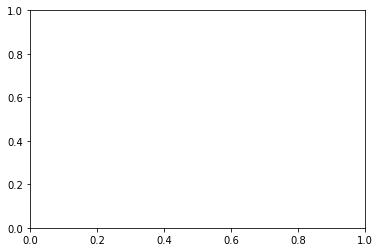

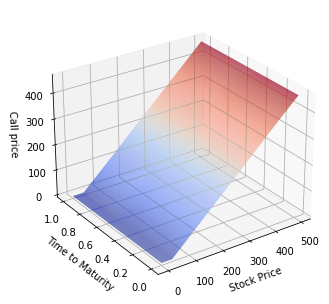

In [ ]:
# 3D plot
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
import warnings
import matplotlib.cbook
warnings.filterwarnings("ignore",category=matplotlib.cbook.mplDeprecation)

fig, ax = plt.subplots()
Y_pred_arr, Y_true_arr = [], []

for t in np.linspace(0, 1, num=1000):
    X_cmp = np.concatenate([t*np.ones((1000, 1)),
                            np.linspace(0, 500, num=1000).reshape(-1, 1),
                           np.linspace(0.03, 0.06, num=1000).reshape(-1, 1),
                           np.linspace(-1, 1, num=1000).reshape(-1, 1)], axis=1)
    Y_pred = model(torch.from_numpy(X_cmp).float().requires_grad_()).cpu().detach()
    Y_true = black_scholes_call_div(X_cmp, K, r, sigma)
    Y_pred_arr.append(np.array(Y_pred))
    Y_true_arr.append(np.array(Y_true))

X, Y = np.meshgrid(np.linspace(0, 500, num=1000), np.linspace(0, 1, num=1000))


Y_pred_arr = np.array(Y_pred_arr).reshape(1000, 1000)
Y_true_arr = np.array(Y_true_arr).reshape(1000, 1000)



figcp = plt.figure()
ax = Axes3D(figcp)
ax.plot_surface(X, Y, Y_pred_arr, rstride=1, cstride=1, cmap=cm.coolwarm, shade='interp')
ax.view_init(27,-125)
ax.set_xlabel('Stock Price')
ax.set_ylabel('Time to Maturity')
ax.set_zlabel('Call price')

figct = plt.figure()
ax = Axes3D(figct)
ax.plot_surface(X, Y, Y_true_arr, rstride=1, cstride=1, cmap=cm.coolwarm, shade='interp')
ax.view_init(27,-125)
ax.set_xlabel('Stock Price')
ax.set_ylabel('Time to Maturity')
ax.set_zlabel('Call price')

plt.show()

In [ ]:
V,Rho = np.meshgrid(np.linspace(0.03, 0.06, num=1000), np.linspace(-1, 1, num=1000))


In [ ]:
import numpy as np
import pandas as pd

In [ ]:
data = pd.DataFrame({
    'Stock_Price': X.flatten(),
    'Time_to_Maturity': Y.flatten(),
    'Volatility': V.flatten(),
    'Correlation': Rho.flatten(),
    'Y_pred_arr': Y_pred_arr.flatten(),
    'Y_true_arr': Y_true_arr.flatten()
})

# Specify the path where you want to save the Excel file
excel_file_path = 'meet stochastic correlation Rho_cs 0.xlsx'

# Save the DataFrame to an Excel file
data.to_excel(excel_file_path, index=False)

print(f'Data saved to {excel_file_path}')


In [46]:
import numpy as np
import pandas as pd

# Your existing code here...

# After generating the data in X, Y, Y_pred_arr, and Y_true_arr:

# Create a DataFrame to organize the data
data = pd.DataFrame({
    'Stock_Price': X.flatten(),
    'Time_to_Maturity': Y.flatten(),
    'extended Heston values': Y_pred_arr.flatten(),
    'Y_true_arr': Y_true_arr.flatten()
})

# Specify the path where you want to save the Excel file
excel_file_path = 'output_data.xlsx'

# Save the DataFrame to an Excel file
data.to_excel(excel_file_path, index=False)

print(f'Data saved to {excel_file_path}')


Data saved to output_data.xlsx
